In [11]:
# Download data from UCSC
import os

CONS_DIR = "./conservation_data"
os.makedirs(CONS_DIR, exist_ok=True)

# phyloP100way (GRCh38)
!curl -L \
  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/phyloP100way/hg38.phyloP100way.bw \
  -o {CONS_DIR}/phyloP100way.bw

# phastCons100way (GRCh38)
!curl -L \
  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/phastCons100way/hg38.phastCons100way.bw \
  -o {CONS_DIR}/phastCons100way.bw

print("Downloaded phyloP100 and phastCons100 bigWig files.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9412M  100 9412M    0     0  40.4M      0  0:03:52  0:03:52 --:--:-- 40.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5613M  100 5613M    0     0  40.3M      0  0:02:19  0:02:19 --:--:-- 40.4M
Downloaded phyloP100 and phastCons100 bigWig files.


In [14]:
# Load bigWig files
import pyBigWig

phyloP_bw = pyBigWig.open(f"{CONS_DIR}/phyloP100way.bw")
phast_bw = pyBigWig.open(f"{CONS_DIR}/phastCons100way.bw")

phyloP_bw.chroms().keys()

dict_keys(['chr1', 'chr10', 'chr10_GL383545v1_alt', 'chr10_GL383546v1_alt', 'chr10_KI270824v1_alt', 'chr10_KI270825v1_alt', 'chr11', 'chr11_GL383547v1_alt', 'chr11_JH159136v1_alt', 'chr11_JH159137v1_alt', 'chr11_KI270721v1_random', 'chr11_KI270826v1_alt', 'chr11_KI270827v1_alt', 'chr11_KI270829v1_alt', 'chr11_KI270830v1_alt', 'chr11_KI270831v1_alt', 'chr11_KI270832v1_alt', 'chr11_KI270902v1_alt', 'chr11_KI270903v1_alt', 'chr11_KI270927v1_alt', 'chr12', 'chr12_GL383549v1_alt', 'chr12_GL383550v2_alt', 'chr12_GL383551v1_alt', 'chr12_GL383552v1_alt', 'chr12_GL383553v2_alt', 'chr12_GL877875v1_alt', 'chr12_GL877876v1_alt', 'chr12_KI270833v1_alt', 'chr12_KI270834v1_alt', 'chr12_KI270835v1_alt', 'chr12_KI270836v1_alt', 'chr12_KI270837v1_alt', 'chr12_KI270904v1_alt', 'chr13', 'chr13_KI270838v1_alt', 'chr13_KI270839v1_alt', 'chr13_KI270840v1_alt', 'chr13_KI270841v1_alt', 'chr13_KI270842v1_alt', 'chr13_KI270843v1_alt', 'chr14', 'chr14_GL000009v2_random', 'chr14_GL000194v1_random', 'chr14_GL000225

In [16]:
# Load ClinVar
import pandas as pd

df = pd.read_csv("./clinvar_data/clinvar_STRICT_with_CADD.csv")
print(df.shape)
df.head()

(262509, 7)


/tmp/ipykernel_4036044/3660953587.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./clinvar_data/clinvar_STRICT_with_CADD.csv")


,CHROM,POS,REF,ALT,CLNSIG,CADD_raw,CADD_phred
0,1,930165,G,A,Benign,4.225333,28.900
1,1,930204,G,A,Benign,2.879554,23.200
2,1,930285,G,A,Benign,0.091394,2.015
3,1,930314,C,T,Benign,2.481464,22.400
4,1,930325,C,T,Benign,1.053778,12.280


In [17]:
# Annotate each ClinVar SNV with new columns 
import numpy as np

phyloP_vals = []
phast_vals = []

for idx, row in df.iterrows():
    chrom = f"chr{row['CHROM']}"
    pos0 = int(row["POS"]) - 1  # convert 1-based → 0-based indexing

    # phyloP
    try:
        phylo = phyloP_bw.values(chrom, pos0, pos0+1)[0]
    except:
        phylo = np.nan

    # phastCons
    try:
        phast = phast_bw.values(chrom, pos0, pos0+1)[0]
    except:
        phast = np.nan

    phyloP_vals.append(phylo)
    phast_vals.append(phast)

df["phyloP100"] = phyloP_vals
df["phastCons100"] = phast_vals

print("Finished annotation.")

Finished annotation.


In [18]:
# Save dataset
df.to_csv("./clinvar_data/clinvar_with_CADD_phyloP_phastCons.csv", index=False)
print("Saved dataset with CADD + phyloP100 + phastCons100.")

Saved dataset with CADD + phyloP100 + phastCons100.


In [19]:
# Verify
df[["CHROM", "POS", "CADD_phred", "phyloP100", "phastCons100"]].head()

,CHROM,POS,CADD_phred,phyloP100,phastCons100
0,1,930165,28.900,5.113,1.000
1,1,930204,23.200,3.430,1.000
2,1,930285,2.015,0.322,0.107
3,1,930314,22.400,3.747,0.081
4,1,930325,12.280,4.888,1.000


In [20]:
# Feature ablation study 
# 1. CADD_phred only: previous baseline
# 2. CADD_raw + CADD_phred: tests if adding raw improves anything
# 3. phyloP100 + phastCons100: tests conservation alone 
# 5. All 4 features 

# Chromsome split
# chr8: validation
# chr18 and chr21: test
# all others: training 

In [21]:
# Load new dataset 
import pandas as pd
import numpy as np

df = pd.read_csv("./clinvar_data/clinvar_with_CADD_phyloP_phastCons.csv")
df["label"] = (df["CLNSIG"] == "Pathogenic").astype(int)

/tmp/ipykernel_4036044/2213830564.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./clinvar_data/clinvar_with_CADD_phyloP_phastCons.csv")


In [22]:
#  Normalize CHROM into consistent numeric format
df["CHROM"] = df["CHROM"].astype(str)                           # ensure strings
df["CHROM"] = df["CHROM"].str.replace("chr", "", regex=False)  # remove "chr" prefix
df["CHROM"] = df["CHROM"].str.replace("MT", "0")                # treat MT separately if needed
df["CHROM"] = pd.to_numeric(df["CHROM"], errors="coerce")       # convert to int; non-numeric → NaN

In [23]:
# Keep only autosomes 1–22
# ------------------------------------------------
df_clean = df[df["CHROM"].isin(range(1,23))].copy()

print("Unique CHROM values after cleaning:", sorted(df_clean["CHROM"].unique()))
print("Dataset size after cleaning:", df_clean.shape)

Unique CHROM values after cleaning: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0]
Dataset size after cleaning: (245253, 10)


In [24]:
# Chromosome-based splits 
TRAIN_CHROMS = [c for c in range(1,23) if c not in [8,18,21]]
VAL_CHROM = 8
TEST_CHROMS = [18, 21]

train_df = df_clean[df_clean["CHROM"].isin(TRAIN_CHROMS)]
val_df   = df_clean[df_clean["CHROM"] == VAL_CHROM]
test_df  = df_clean[df_clean["CHROM"].isin(TEST_CHROMS)]

print("\nTrain class counts:\n", train_df["label"].value_counts())
print("\nVal class counts:\n", val_df["label"].value_counts())
print("\nTest class counts:\n", test_df["label"].value_counts())


Train class counts:
 label
0    158471
1     69518
Name: count, dtype: int64

Val class counts:
 label
0    6107
1    2696
Name: count, dtype: int64

Test class counts:
 label
0    6383
1    2078
Name: count, dtype: int64


In [31]:
# Features 
FEATURE_SETS = {
    "CADD_phred_only": ["CADD_phred"],
    "CADD_raw_only": ["CADD_raw"],
    "CADD_raw_phred": ["CADD_raw", "CADD_phred"],
    "conservation_only": ["phyloP100", "phastCons100"],
    "all_features": ["CADD_raw", "CADD_phred", "phyloP100", "phastCons100"],
}

In [32]:
# Safe AUC calculator (prevents crashes with single-class issues)
def safe_auc(y_true, y_score):
    unique = np.unique(y_true)
    if len(unique) < 2:
        return None
    return roc_auc_score(y_true, y_score)

In [33]:
# Logistic Regression on each feature set
# Logistic Regression Baseline 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

def run_logreg(feature_list):
    print("\n=====================================================")
    print("Feature Set:", feature_list)
    print("=====================================================")

    # Extract feature matrices
    X_train = train_df[feature_list].fillna(0).values
    y_train = train_df["label"].values

    X_val = val_df[feature_list].fillna(0).values
    y_val = val_df["label"].values

    X_test = test_df[feature_list].fillna(0).values
    y_test = test_df["label"].values

    # Train model
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, y_train)

    # Validation
    val_scores = clf.predict_proba(X_val)[:, 1]
    val_auc = safe_auc(y_val, val_scores)
    print(f"Validation AUROC (chr{VAL_CHROM}): {val_auc}")

    # Test
    test_scores = clf.predict_proba(X_test)[:, 1]
    test_auc = safe_auc(y_test, test_scores)
    print(f"Test AUROC (chr18 + chr21): {test_auc}")

    print("\nTest Classification Report:")
    print(classification_report(y_test, clf.predict(X_test)))

In [35]:
# Run all 
for name, feats in FEATURE_SETS.items():
    print(f"\n\n######## Running Feature Set: {name} ########")
    run_logreg(feats)



######## Running Feature Set: CADD_phred_only ########

Feature Set: ['CADD_phred']
Validation AUROC (chr8): 0.8512862422797403
Test AUROC (chr18 + chr21): 0.8267764757113948

Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      6383
           1       0.00      0.00      0.00      2078

    accuracy                           0.75      8461
   macro avg       0.38      0.50      0.43      8461
weighted avg       0.57      0.75      0.65      8461



######## Running Feature Set: CADD_raw_only ########

Feature Set: ['CADD_raw']
Validation AUROC (chr8): 0.43178678915424673
Test AUROC (chr18 + chr21): 0.4700084982713195

Test Classification Report:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.77      1.00      0.87      6383
           1       0.99      0.08      0.15      2078

    accuracy                           0.77      8461
   macro avg       0.88      0.54      0.51      8461
weighted avg       0.82      0.77      0.69      8461



######## Running Feature Set: CADD_raw_phred ########

Feature Set: ['CADD_raw', 'CADD_phred']
Validation AUROC (chr8): 0.9705876690124045
Test AUROC (chr18 + chr21): 0.9615558018720625

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      6383
           1       0.81      0.97      0.88      2078

    accuracy                           0.94      8461
   macro avg       0.90      0.95      0.92      8461
weighted avg       0.95      0.94      0.94      8461



######## Running Feature Set: conservation_only ########

Feature Set: ['phyloP100', 'phastCons100']
Validation AUROC (chr8): 0

In [39]:
# Prepare results for plotting
results = {}

for name, feat_list in FEATURE_SETS.items():
    print("Collecting:", name)
    
    X_train = train_df[feat_list].fillna(0).values
    y_train = train_df["label"].values

    X_test = test_df[feat_list].fillna(0).values
    y_test = test_df["label"].values

    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]

    results[name] = {
        "y_true": y_test,
        "y_score": y_score
    }

Collecting: CADD_phred_only
Collecting: CADD_raw_only
Collecting: CADD_raw_phred
Collecting: conservation_only
Collecting: all_features


In [40]:
results.keys()

dict_keys(['CADD_phred_only', 'CADD_raw_only', 'CADD_raw_phred', 'conservation_only', 'all_features'])

In [46]:
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)

# =================================================
# AUROC ABLATION BAR PLOT
# =================================================
def plot_auroc_bar(results):
    auroc_values = {
        name: roc_auc_score(data["y_true"], data["y_score"])
        for name, data in results.items()
    }

    items = sorted(auroc_values.items(), key=lambda x: x[1], reverse=True)
    labels = [i[0] for i in items]
    scores = [i[1] for i in items]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, scores, color="steelblue")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Test AUROC")
    plt.title("Feature Ablation Study: Test AUROC")
    plt.ylim(0, 1.0)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


# =================================================
# ROC CURVE OVERLAY
# =================================================
def plot_roc_curves(results):
    plt.figure(figsize=(8, 6))
    feature_sets = [
        "CADD_phred_only",
        "conservation_only",
        "CADD_raw_phred",
        "all_features",
    ]

    for name in feature_sets:
        if name not in results:
            continue
        d = results[name]
        fpr, tpr, _ = roc_curve(d["y_true"], d["y_score"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUROC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison Across Feature Sets")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


# =================================================
# PRECISION–RECALL CURVE OVERLAY
# =================================================
def plot_pr_curves(results):
    plt.figure(figsize=(8, 6))
    feature_sets = [
        "CADD_phred_only",
        "conservation_only",
        "CADD_raw_phred",
        "all_features",
    ]

    for name in feature_sets:
        if name not in results:
            continue
        d = results[name]
        precision, recall, _ = precision_recall_curve(d["y_true"], d["y_score"])
        plt.plot(recall, precision, lw=2, label=name)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve Comparison")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

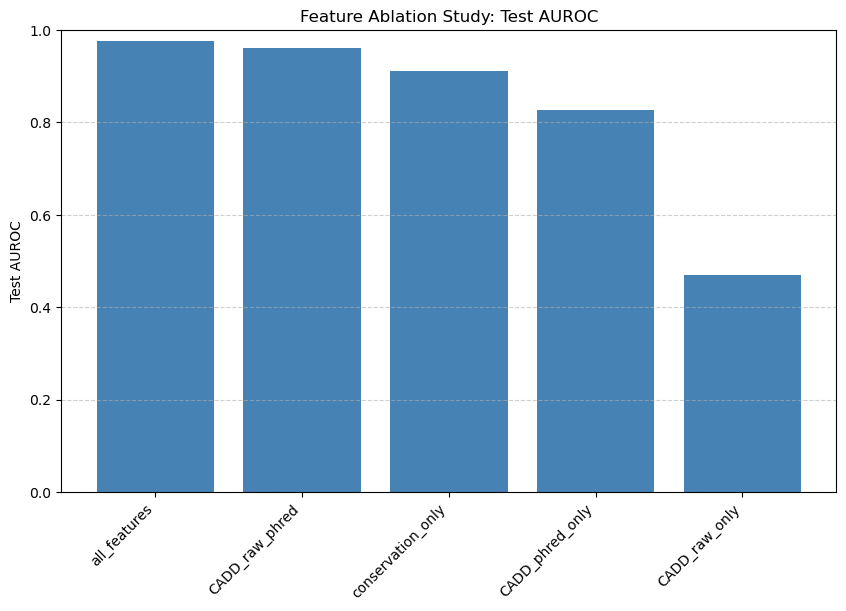

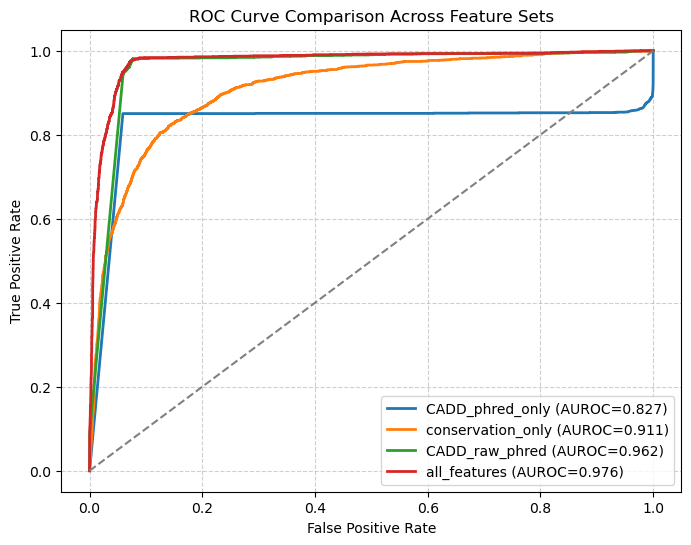

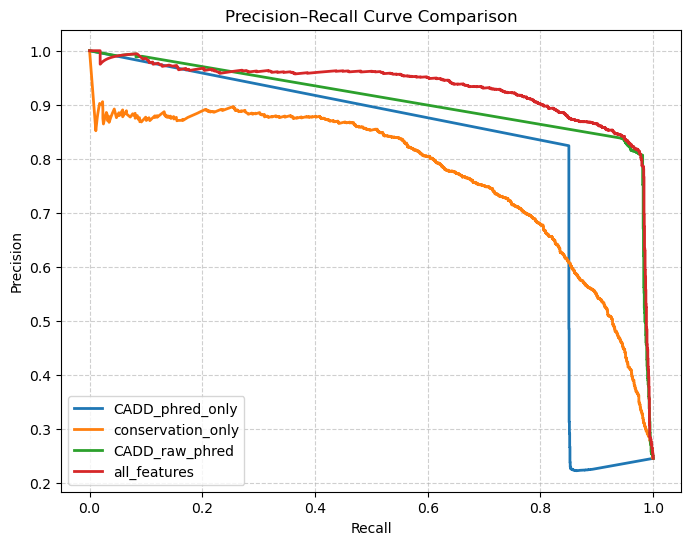

In [50]:
%matplotlib inline

plot_auroc_bar(results)
plot_roc_curves(results)
plot_pr_curves(results)

In [51]:
# Trying with xgboost 
from xgboost import XGBClassifier

def run_xgboost(feature_list, return_preds=False):
    print("\n=====================================================")
    print("XGBoost Feature Set:", feature_list)
    print("=====================================================")

    X_train = train_df[feature_list].fillna(0).values
    y_train = train_df["label"].values

    X_val = val_df[feature_list].fillna(0).values
    y_val = val_df["label"].values

    X_test = test_df[feature_list].fillna(0).values
    y_test = test_df["label"].values

    # XGBoost model
    clf = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="hist",        # FAST on CPU
        n_jobs=4
    )

    clf.fit(X_train, y_train)

    # Validation AUROC
    val_probs = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    print(f"Validation AUROC (chr{VAL_CHROM}): {val_auc}")

    # Test AUROC
    test_probs = clf.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_probs)
    print(f"Test AUROC (chr18 + chr21): {test_auc}")

    print("\nTest Classification Report:")
    print(classification_report(y_test, clf.predict(X_test)))

    if return_preds:
        return y_test, test_probs

In [52]:
results_xgb = {}

for name, feats in FEATURE_SETS.items():
    print(f"\n\n######## Running XGBoost Feature Set: {name} ########")
    y_true, y_score = run_xgboost(feats, return_preds=True)
    results_xgb[name] = {
        "y_true": y_true,
        "y_score": y_score
    }

print("Finished running XGBoost on all feature sets!")



######## Running XGBoost Feature Set: CADD_phred_only ########

XGBoost Feature Set: ['CADD_phred']
Validation AUROC (chr8): 0.9775272173926987
Test AUROC (chr18 + chr21): 0.9683875540434115

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      6383
           1       0.83      0.96      0.89      2078

    accuracy                           0.94      8461
   macro avg       0.91      0.95      0.93      8461
weighted avg       0.95      0.94      0.94      8461



######## Running XGBoost Feature Set: CADD_raw_only ########

XGBoost Feature Set: ['CADD_raw']
Validation AUROC (chr8): 0.9763388707515187
Test AUROC (chr18 + chr21): 0.966539753016351

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      6383
           1       0.82      0.96      0.89      2078

    accuracy                           0.94      8461
   macro avg    

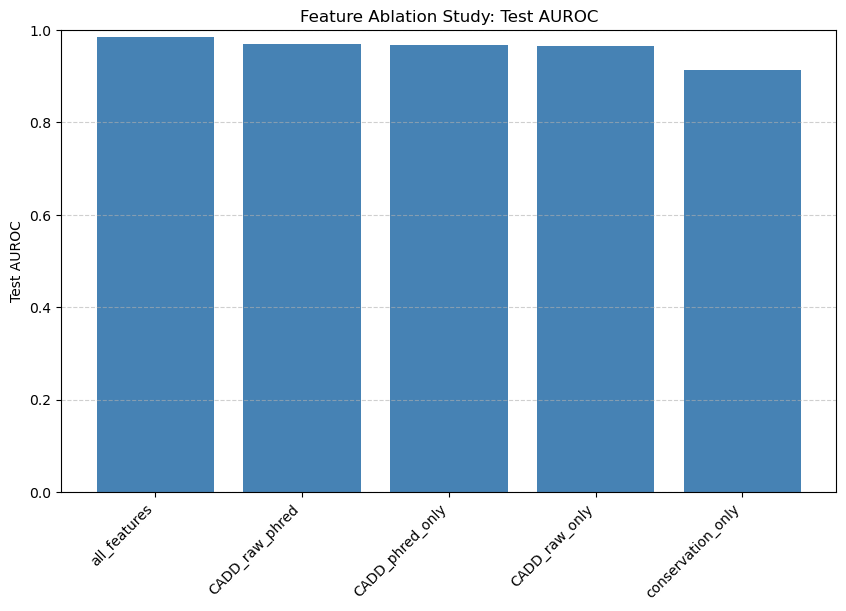

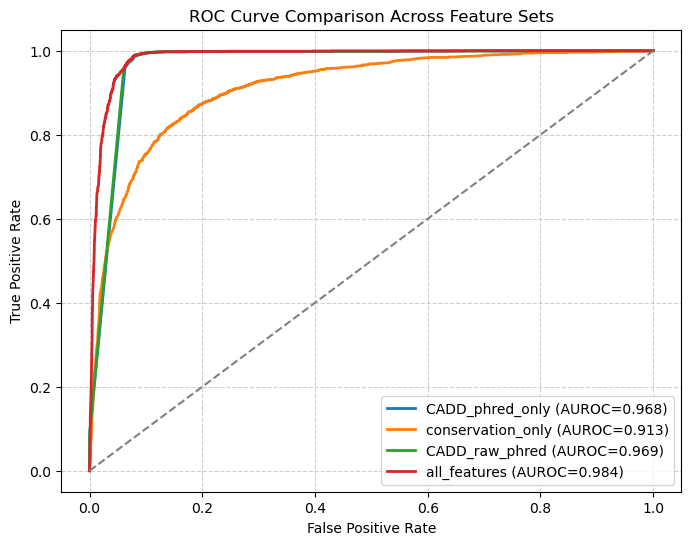

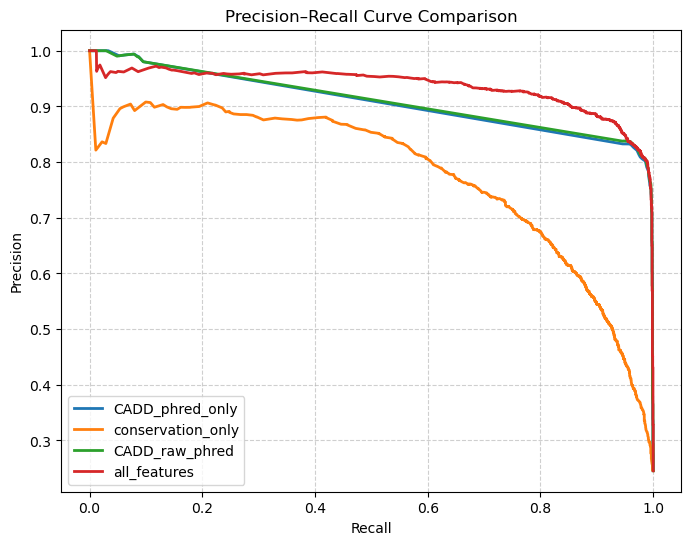

In [53]:
# Plots
plot_auroc_bar(results_xgb)
plot_roc_curves(results_xgb)
plot_pr_curves(results_xgb)